# Filtering barotropic tide 

This notebook aims at filetring High Frequency SSH and removing barotropic tide (large scale signal) with low pass spatial filter. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pyinterp import fill, Axis, TemporalAxis, Grid3D, Grid2D
import scipy.fftpack as fp
from scipy.interpolate import RegularGridInterpolator, griddata
from math import *
from dask import delayed,compute
from joblib import Parallel
from joblib import delayed as jb_delayed

## 1. - Data import 

Mask is imported from **"/bettik/bellemva/MITgcm/mask/mask.nc"**.

In [2]:
mask = xr.open_dataset("/bettik/bellemva/MITgcm/mask/mask.nc")

The Dataset of all SSH variables is loaded with xarray.

In [3]:
ds = xr.open_dataset("/bettik/bellemva/MITgcm/MITgcm_filtered_final/MITgcm_filt_20120605.nc")

A DataArray is created with High Frequency (HF) Sea Surface Height. It is downgraded at the solution 1/12°. 

In [4]:
ssh_hf = ds.ssh_hf.coarsen(longitude=4,latitude=4,boundary='trim').mean()
ssh_hf = ssh_hf.load().chunk({'time':1})

## 2. - Data processing 

Prior to processing, the HF SSH needs to be processed. First of all, NaNs are filled by interpolation. 

In [5]:
x_axis = Axis(ssh_hf.longitude.values,is_circle=True)
y_axis = Axis(ssh_hf.latitude.values,is_circle=True)
t_axis = TemporalAxis(ssh_hf.time.values)

grid = Grid3D(y_axis, x_axis, t_axis, ssh_hf.values.transpose(1,2,0))
has_converged, filled = fill.gauss_seidel(grid,num_threads=4)

ssh_hf_filled = ssh_hf.copy(deep=True,data=filled.transpose(2,0,1)).chunk({'time':1})


The filled SSH is interpolated on a cartesian grid (regular in distance). Two empty bands of NaNs are situated on each side of the region. They are filled with interpolation. 

In [13]:
dx = 10 # in kilometers, spacing of the grid 

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.latitude.values,
                                                         ssh_hf_filled.longitude.values,
                                                         dx)

array_cart_ssh = ssh_hf_filled.interp(latitude=('z',ENSLAT2D.flatten()),
                                      longitude=('z',ENSLON2D.flatten()),
                                     ).values

# INTERPOLATION OF NaNs # 
x_axis = Axis(np.arange(i_lon))
y_axis = Axis(np.arange(i_lat))
t_axis = TemporalAxis(ssh_hf.time.values)

grid = Grid3D(y_axis, x_axis, t_axis, array_cart_ssh.reshape((24,i_lat,i_lon)).transpose(1,2,0))
has_converged, filled = fill.gauss_seidel(grid,num_threads=4)

mask_cart = np.isnan(array_cart_ssh[0].reshape((i_lat,i_lon)))

# CREATION OF DataArray #
cart_ssh_hf = xr.DataArray(data=filled.transpose(2,0,1),
                          dims=["time","y","x"],
                          coords = dict(
                              time = ssh_hf_filled.time.values,
                              y=(["y"],np.arange(i_lat)),
                              x=(["x"],np.arange(i_lon))
                          )).chunk({'time':1})

## 3. - Extracting barotropic tide 

The barotropic tide is extracted with the function **extract_bar_tide**. Joblib delayed package is used for parellizing over the time steps. 

In [15]:
window = create_spatial_window(nx=i_lon, ny=i_lat)

cart_ssh_filtered = np.array(Parallel(n_jobs=4,backend='multiprocessing')(jb_delayed(extract_bar_tide)(cart_ssh_hf[i].values,dx,window) for i in range(24)))

The grid is interpolated over a geodesic grid with **scipy.interpolate.griddata**. This operation is parallelized with Joblib. 

In [54]:
lon2d, lat2d = np.meshgrid(ssh_hf.longitude.values, ssh_hf.latitude.values)

geo_filtered = np.array(Parallel(n_jobs=24,backend='multiprocessing')(jb_delayed(griddata)(np.array([ENSLAT2D.flatten(),ENSLON2D.flatten()]).T,
                                     cart_ssh_filtered[i].flatten(),
                                     (lat2d,lon2d),'cubic') for i in range(24)))

In [55]:
ssh_filtered = ssh_hf.copy(deep=True,data=geo_filtered).chunk({'time':1})

In [56]:
ssh_filtered = ssh_filtered.interp_like(ds,kwargs={"fill_value": "extrapolate"})

In [57]:
mask = np.load("/bettik/bellemva/MITgcm/mask/mask_MITgcm_nobay.npy")

In [58]:
ssh_filtered = ssh_filtered.where(mask==False,np.nan)

In [51]:
ssh_filtered = ssh_filtered.rename("ssh_bar")

In [52]:
ssh_filtered.to_netcdf("/bettik/bellemva/MITgcm/test.nc")

## Functions 

In [7]:
def create_cartesian_grid (latitude,longitude,dx):
    """ 
    Creates a cartesian grid (regular in distance, kilometers) from a geodesic latitude, longitude grid. 
    The new grid is expressed in latitude, longitude coordinates.

    Parameters
    ----------
    longitude : numpy ndarray 
        Vector of longitude for geodesic input grid. 
    latitude : numpy ndarray 
        Vector of latitude for geodesic input grid. 
    dx : float 
        Grid spacing in kilometers. 

    Returns
    -------
    ENSLAT2D : 
        2-D numpy ndarray of the latitudes of the points of the cartesian grid 
    ENSLON2D : 
        2-D numpy ndarray of the longitudes of the points of the cartesian grid 
    """
    km2deg = 1/111

    # ENSEMBLE OF LATITUDES # 
    ENSLAT = np.arange(latitude[0],latitude[-1]+dx*km2deg,dx*km2deg)
    range_lon = longitude[-1]-longitude[0]

    if longitude.size%2 == 0 : 
        nstep_lon = floor(range_lon/(dx*km2deg))+2
    else : 
        nstep_lon = ceil(range_lon/(dx*km2deg))+2
    ENSLAT2D = np.repeat(np.expand_dims(ENSLAT,axis=1),axis=1,repeats=nstep_lon)

    # ENSEMBLE OF LATITUDES # 
    mid_lon = (longitude[-1]+longitude[0])/2
    ENSLON2D=np.zeros_like(ENSLAT2D)

    for i in range(len(ENSLAT)):
        d_lon = dx*km2deg*(np.cos(np.pi*latitude[0]/180)/np.cos(np.pi*latitude[i]/180))
        d_lon_range = np.array([i*d_lon for i in range (1,int(nstep_lon/2)+1)])
        lon_left = np.flip(mid_lon-d_lon_range)
        lon_right = mid_lon+d_lon_range
        ENSLON2D[i,:]=np.concatenate((lon_left,lon_right))

    return ENSLAT2D, ENSLON2D, ENSLAT2D.shape[0], ENSLAT2D.shape[1]
    

In [8]:
def lowpass(_lambda,nx,ny,wavenum2D) : 
    _lowpass = np.zeros((3*ny,3*nx))
    for i in range (3*ny):
        for j in range(3*nx):
            if wavenum2D[i,j]<1/_lambda:
                _lowpass[i,j] = 1
    return _lowpass 

In [9]:
def extend(ssh,nx,ny):
    ssh_extended = np.empty((3*ny,3*nx))
    ssh_extended[ny:2*ny,nx:2*nx] = +ssh
    ssh_extended[0:ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[2*ny:3*ny,nx:2*nx] = +ssh[::-1,:]
    ssh_extended[:,0:nx] = ssh_extended[:,nx:2*nx][:,::-1]
    ssh_extended[:,2*nx:3*nx] = ssh_extended[:,nx:2*nx][:,::-1]
    return ssh_extended

In [10]:
def gaspari_cohn(array,distance,center):
    """
    NAME 
        bfn_gaspari_cohn

    DESCRIPTION 
        Gaspari-Cohn function. @vbellemin.
        
        Args: 
            array : array of value whose the Gaspari-Cohn function will be applied
            center : centered value of the function 
            distance : Distance above which the return values are zeros


        Returns:  smoothed values 
            
    """ 
    if type(array) is float or type(array) is int:
        array = np.array([array])
    else:
        array = array
    if distance<=0:
        return np.zeros_like(array)
    else:
        array = 2*np.abs(array-center*np.ones_like(array))/distance
        gp = np.zeros_like(array)
        i= np.where(array<=1.)[0]
        gp[i]=-0.25*array[i]**5+0.5*array[i]**4+0.625*array[i]**3-5./3.*array[i]**2+1.
        i =np.where((array>1.)*(array<=2.))[0]
        gp[i] = 1./12.*array[i]**5-0.5*array[i]**4+0.625*array[i]**3+5./3.*array[i]**2-5.*array[i]+4.-2./3./array[i]
        #if type(r) is float:
        #    gp = gp[0]
    return gp

In [11]:
def create_spatial_window(nx,ny):
    result = np.ones((3*ny,3*nx))
    
    gaspari_x = np.expand_dims(gaspari_cohn(np.arange(2*nx),nx,nx),axis=0)
    gaspari_y = np.expand_dims(gaspari_cohn(np.arange(2*ny),ny,ny),axis=1)

    #paving edges with gaspari-cohn
    result[2*ny:,nx:2*nx] = np.repeat(gaspari_y[ny:,:],repeats=nx,axis=1)
    result[:ny,nx:2*nx] = np.repeat(gaspari_y[:ny,:],repeats=nx,axis=1)
    result[ny:2*ny,0:nx] = np.repeat(gaspari_x[:,:nx],repeats=ny,axis=0)
    result[ny:2*ny,2*nx:] = np.repeat(gaspari_x[:,nx:],repeats=ny,axis=0)

    #paving corners with gaspari-cohn
    result[2*ny:,2*nx:]=gaspari_y[ny:,:]*gaspari_x[:,nx:]
    result[:ny,:nx]=gaspari_y[:ny,:]*gaspari_x[:,:nx]
    result[2*ny:,:nx]=gaspari_y[ny:,:]*gaspari_x[:,:nx]
    result[:ny,2*nx:]=gaspari_y[:ny,:]*gaspari_x[:,nx:]

    return result 

In [12]:
def extract_bar_tide(ssh0,dx,window):

    nx = ssh0.shape[1]
    ny = ssh0.shape[0]

    kx = np.fft.fftfreq(3*nx,dx) # km
    ky = np.fft.fftfreq(3*ny,dx) # km
    k, l = np.meshgrid(kx,ky)
    wavenum2D = np.sqrt(k**2 + l**2)

    lambda_bar = 400
    lowpass_bar = lowpass(lambda_bar,nx,ny,wavenum2D)

    ssh = extend(ssh0,nx,ny)
    ssh = ssh * window
    ssh_freq = fp.fft2(ssh)
    ssh_freq_filtered = lowpass_bar * ssh_freq
    ssh_filtered = np.real(fp.ifft2(ssh_freq_filtered))[ny:2*ny,nx:2*nx]

    return ssh_filtered


In [4]:
import xarray as xr 
import matplotlib.pyplot as plt
mask = xr.open_dataset("/bettik/bellemva/MITgcm/mask/mask.nc")

mask

<xarray.Dataset>
Dimensions:    (time: 24, latitude: 1681, longitude: 3121)
Coordinates:
  * time       (time) datetime64[ns] 2012-08-01 ... 2012-08-01T23:00:00
  * latitude   (latitude) float32 10.0 10.02 10.04 10.06 ... 44.96 44.98 45.0
  * longitude  (longitude) float32 180.0 180.0 180.0 180.1 ... 245.0 245.0 245.0
Data variables:
    mask       (time, latitude, longitude) bool ...
Attributes:
    history:  Thu Apr 27 16:37:41 2023: ncrename -v __xarray_dataarray_variab...
    NCO:      netCDF Operators version 4.9.8 (Homepage = http://nco.sf.net, C...

(1000.0, 1500.0)

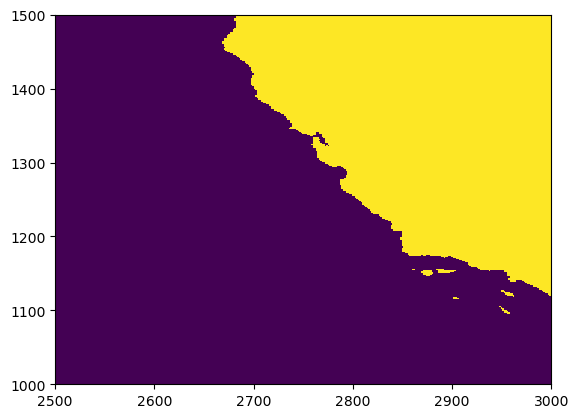

In [8]:
plt.pcolormesh(mask.mask.values[0])
plt.xlim((2500,3000))
plt.ylim((1000,1500))